In [9]:
%reset -f
import sys
# sys.path.append("/home/jose/Documents/Maestria/Codigo/OTI/build/")
# sys.path.append("/Users/maristi7/coding/otilib/build")
# sys.path.append("anterior/")
import Calc_Cable as cab
# import Calc_Cable_20201116 as cab_old
import pyoti.sparse as oti
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
    "font.size": 12,
    "font.sans-serif": ["Helvetica"]
})

In [10]:
order = 2
nbases = 7
l,h,L0,A0,E,w,cargas = cab.leer_entradas("Irvine_1")
cargas = cargas.astype(object)
F = cargas[0][0]
F = F + oti.e(1,order=order)
cargas[0][0] = F
#convertir adimensionales
gamma,delta,beta,Psi,Sigmas = cab.param_adim(l,h,L0,A0,E,w,cargas)
#calcular las incognitas gi fi
gi_0, fi_0 = 0.275, 0.275 #valores iniciales para iterar en newton
gi,fi = cab.calc_gi_fi(order,nbases,gamma,delta,beta,Psi,Sigmas,gi_0,fi_0)

Conf. 0: x = 0.29076897820306424 , y = 0.1362093317460752
Conf. 1: x = 0.22383389623785754 , y = 0.24128017734375387
Conf. 2: x = 0.19994612779783041 , y = 0.26233398976124506


<IPython.core.display.Javascript object>


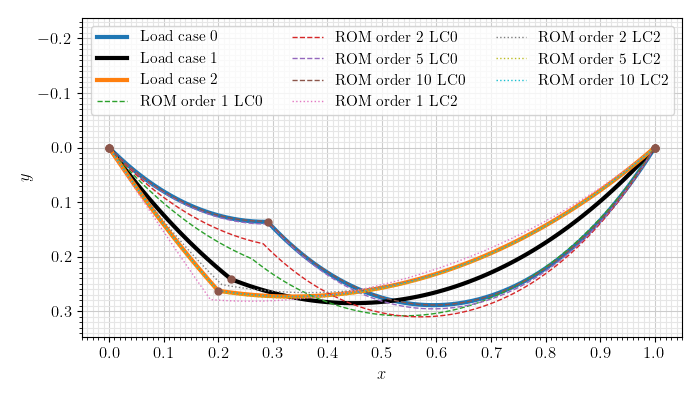

In [11]:
#SOLUCION PARA EL CABLE DEL PAPER IRVINE
order = 9
nbases = 7

plt.figure(figsize=(7,4))

Xsol = []
Fsol = []
for u in range(3):
    #Lectura de datos de entrada
    l,h,L0,A0,E,w,cargas = cab.leer_entradas("Irvine_"+str(u))
    cargas = cargas.astype(object)
    F = cargas[0][0]
    Fsol.append(F)
    #Pertubar parametros 
#     e1 = oti.e(1,nbases=nbases, order=order)
#     e2 = oti.e(2,nbases=nbases, order=order)
#     e3 = oti.e(3,nbases=nbases, order=order)
#     e4 = oti.e(4,nbases=nbases, order=order)
#     e5 = oti.e(5,nbases=nbases, order=order)
#     e6 = oti.e(6,nbases=nbases, order=order)
    e7 = oti.e(1,nbases=nbases, order=order)
#     l = l + e1
#     h = h + e2
#     L0 = L0 + e3
#     A0 = A0 + e4
#     E = E + e5
#     w = w + e6
    F = F + e7
    cargas[0][0] = F

    #convertir adimensionales
    gamma,delta,beta,Psi,Sigmas = cab.param_adim(l,h,L0,A0,E,w,cargas)

    #calcular las incognitas gi fi
    gi_0, fi_0 = 0.275, 0.275 #valores iniciales para iterar en newton
    gi,fi = cab.calc_gi_fi(order,nbases,gamma,delta,beta,Psi,Sigmas,gi_0,fi_0)
    #print(gi.real*w.real*L0.real,fi.real*w.real*L0.real)
    
    #calcular curva
    p = 100 #puntos de la curva
    A = cab.curva(nbases,order,gi,fi,beta,Psi,Sigmas,p)

    #Convertir a dimensionales    
    x = (A[:,0]*L0).get_deriv(0)
    y = (A[:,1]*L0).get_deriv(0)
    T = (A[:,2]*w*L0).get_deriv(0)
    
    Xsol.append(A[:,:2]*L0)
    color = None
    if u==1:
        color='k'
    # end if 
    cab.plot_curva(x,y,T,u,np.array([[None]]), [None], [None], [None],color=color )
    
    #Calculo de curvas por modelo de orden reducido
    if u==2:
        x_1 = Xsol[1][:,0]
        y_1 = Xsol[1][:,1]
        for ordi in [1,2,5,10]:
            x_1_t = x_1.truncate_order(ordi)
            y_1_t = y_1.truncate_order(ordi)
            x_0 = x_1_t.rom_eval([1],[Fsol[0]-Fsol[1]]).get_deriv(0)
            y_0 = y_1_t.rom_eval([1],[Fsol[0]-Fsol[1]]).get_deriv(0)
            plt.plot(x_0,y_0, '--', lw=1.0, label="ROM order {0} LC0".format(ordi))
            
        for ordi in [1,2,5,10]:
            x_1_t = x_1.truncate_order(ordi)
            y_1_t = y_1.truncate_order(ordi)
            x_2 = x_1_t.rom_eval([1],[Fsol[2]-Fsol[1]]).get_deriv(0)
            y_2 = y_1_t.rom_eval([1],[Fsol[2]-Fsol[1]]).get_deriv(0)
            plt.plot(x_2,y_2, ':', lw=1.0, label="ROM order {0} LC2".format(ordi))

    #Graficar cable
#     if u==0 or u==1:
#         cab.plot_curva(x,y,T,u,np.array([[None]]), [None], [None], [None] )
    
#     else:
#         cab.plot_curva(x,y,T,u,x_0,x_2,y_0,y_2)
        
       
        
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))



plt.grid(which='major', color=(0.8,0.8,0.8))
plt.grid(which='minor', color=(0.9,0.9,0.9))

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.axis('equal')

plt.legend(ncol=3,fontsize=11)

vals = ax.get_ylim()
ax.set_ylim((vals[0]-0.1,vals[1]-0.1))
plt.tight_layout()

plt.savefig("Irvine_oti.pdf")

plt.show()

<IPython.core.display.Javascript object>


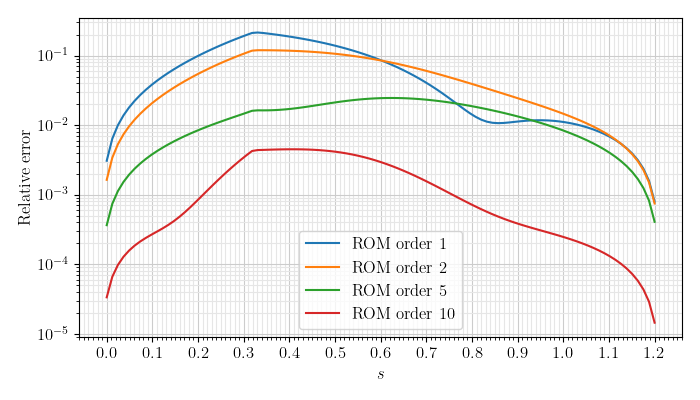

[None, None, None, None]

Order: 1
 0.0216936 - 9.20971e-05 * e([1])
0.06754267692722633

Order: 2
 0.0216936 - 9.20971e-05 * e([1]) + 2.03162e-06 * e([[1,2]])
0.0463985198741123

Order: 5
 0.0216936 - 9.20971e-05 * e([1]) + 2.03162e-06 * e([[1,2]]) - 3.80604e-08 * e([[1,3]]) + 7.24528e-10 * e([[1,4]]) - 1.58002e-11 * e([[1,5]])
0.010632243410051409

Order: 10
 0.0216936 - 9.20971e-05 * e([1]) + 2.03162e-06 * e([[1,2]]) - 3.80604e-08 * e([[1,3]]) + 7.24528e-10 * e([[1,4]]) - 1.58002e-11 * e([[1,5]]) + 4.00178e-13 * e([[1,6]]) - 1.09329e-14 * e([[1,7]]) + 2.96597e-16 * e([[1,8]]) - 7.48456e-18 * e([[1,9]])
0.0015894187771825522
[[0.06754267692722633], [0.0463985198741123], [0.010632243410051409], [0.0015894187771825522]]


In [22]:

plt.figure(figsize=(7,4))

# Error
rom = Xsol[1]
exac= Xsol[0]
NRMSEs = [None]*4
print(NRMSEs)
i=0
for ordi in [1,2,5,10]:
    NRMSEs[i]=[]
    rom_eval = rom.truncate_order(ordi)
    
    print("\nOrder: {0}".format(ordi))
    print(rom_eval[3,0])

    p_rom = rom_eval.rom_eval([1],[Fsol[0]-Fsol[1]]).real

    p_exac = exac.real
    
    se = (p_rom-p_exac)**2
    
    mse = np.sum(se)/se.size
    rmse = np.sqrt(mse)
    nrmse = rmse/p_exac.mean()
    print(nrmse)
    NRMSEs[i].append(nrmse)
    
    err = np.linalg.norm(p_rom-p_exac,axis=1)/p_exac.mean()#L0.real

    plt.semilogy((L0.real*np.linspace(0,1,p-1)),err[1:-1],label='ROM order '+str(ordi))
    i+=1

# end for 
print(NRMSEs)
ax = plt.gca()

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.grid(which='major', color=(0.8,0.8,0.8))
plt.grid(which='minor', color=(0.9,0.9,0.9))

plt.xlabel(r'$s$')
plt.ylabel(r'Relative error')

plt.legend()

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


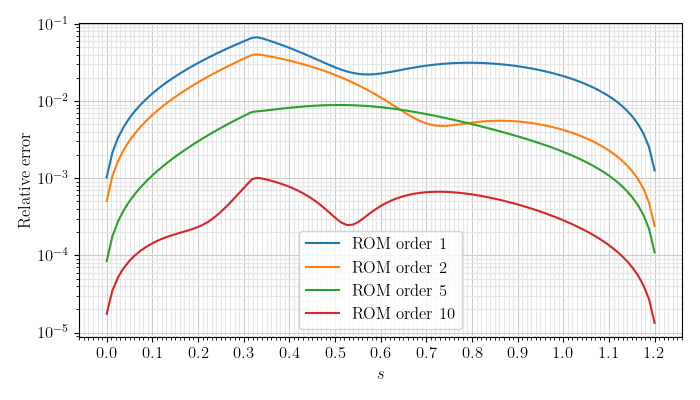


Order: 1
 0.0216936 - 9.20971e-05 * e([1])
0.021629535397271745

Order: 2
 0.0216936 - 9.20971e-05 * e([1]) + 2.03162e-06 * e([[1,2]])
0.011799544633326081

Order: 5
 0.0216936 - 9.20971e-05 * e([1]) + 2.03162e-06 * e([[1,2]]) - 3.80604e-08 * e([[1,3]]) + 7.24528e-10 * e([[1,4]]) - 1.58002e-11 * e([[1,5]])
0.0037851351885006524

Order: 10
 0.0216936 - 9.20971e-05 * e([1]) + 2.03162e-06 * e([[1,2]]) - 3.80604e-08 * e([[1,3]]) + 7.24528e-10 * e([[1,4]]) - 1.58002e-11 * e([[1,5]]) + 4.00178e-13 * e([[1,6]]) - 1.09329e-14 * e([[1,7]]) + 2.96597e-16 * e([[1,8]]) - 7.48456e-18 * e([[1,9]])
0.0003311643186209142


In [23]:

plt.figure(figsize=(7,4))

# Error
rom = Xsol[1]
exac= Xsol[2]

i=0
for ordi in [1,2,5,10]:
    
    rom_eval = rom.truncate_order(ordi)
    
    print("\nOrder: {0}".format(ordi))
    print(rom_eval[3,0])

    p_rom = rom_eval.rom_eval([1],[Fsol[2]-Fsol[1]]).real

    p_exac = exac.real
    
    se = (p_rom-p_exac)**2
    
    mse = np.sum(se)/se.size
    rmse = np.sqrt(mse)
    nrmse = rmse/p_exac.mean()
    print(nrmse)
    err = np.linalg.norm(p_rom-p_exac,axis=1)/p_exac.mean()#L0.real
    NRMSEs[i].append(nrmse)
    plt.semilogy((L0.real*np.linspace(0,1,p-1)),err[1:-1],label='ROM order '+str(ordi))
    i+=1
# end for 

ax = plt.gca()

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.grid(which='major', color=(0.8,0.8,0.8))
plt.grid(which='minor', color=(0.9,0.9,0.9))

plt.xlabel(r'$s$')
plt.ylabel(r'Relative error')

plt.legend()

plt.tight_layout()
plt.show()

In [24]:
NRMSEs = np.array(NRMSEs)
NRMSEs

array([[0.06754268, 0.02162954],
       [0.04639852, 0.01179954],
       [0.01063224, 0.00378514],
       [0.00158942, 0.00033116]])

<IPython.core.display.Javascript object>


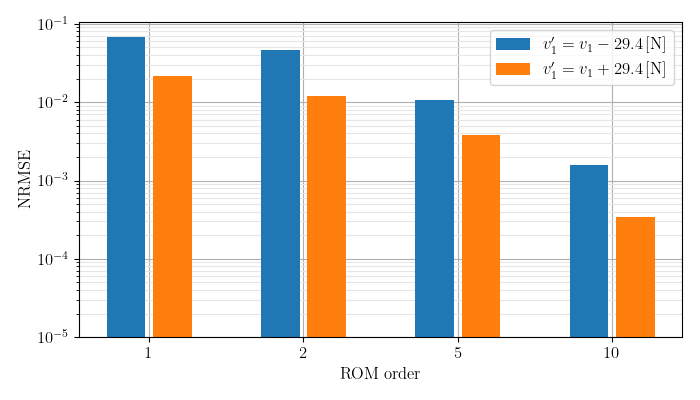

In [34]:
plt.figure(figsize=(7,4))

x = np.arange(NRMSEs.shape[0])
des = .15
plt.bar(x-des,NRMSEs[:,0],width=0.25,bottom=1e-5,label=r"$v_{1}'=v_1-29.4 \left[\mbox{N}\right]$")
plt.bar(x+des,NRMSEs[:,1],width=0.25,bottom=1e-5,label=r"$v_{1}'=v_1+29.4 \left[\mbox{N}\right]$")

ax = plt.gca()
ax.set_yscale('log')
ax.set_xticks(x)
ax.set_xticklabels([1,2,5,10])

ax.set_axisbelow(True)

plt.grid()
plt.grid(which='minor',color=(0.9,0.9,0.9))

plt.legend()
plt.ylabel('NRMSE')
plt.xlabel('ROM order')
plt.tight_layout()
plt.savefig("NRMSE_ROM_Irvine.pdf",dpi=300)
plt.show()

In [6]:
#SOLUCION PARA EL CABLE DEL PAPER IRVINE
order = 2
nbases = 6

for u in range(3):
    #Lectura de datos de entrada
    l,h,L0,A0,E,w,cargas = cab_old.leer_entradas("Irvine_"+str(u))
    
    #Pertubar parametros (no sirve para perturbar cargas y ubicacion s de las cargas)
    e1 = oti.e(1,nbases=nbases, order=order)
    e2 = oti.e(2,nbases=nbases, order=order)
    e3 = oti.e(3,nbases=nbases, order=order)
    e4 = oti.e(4,nbases=nbases, order=order)
    e5 = oti.e(5,nbases=nbases, order=order)
    e6 = oti.e(6,nbases=nbases, order=order)
    l = l + e1
    h = h + e2
    L0 = L0 + e3
    A0 = A0 + e4
    E = E + e5
    w = w + e6

    #convertir adimensionales
    gamma,delta,beta,Psi,Sigmas = cab_old.param_adim(l,h,L0,A0,E,w,cargas)

    #calcular las incognitas gi fi
    gi_0, fi_0 = 0.275, 0.275 #valores iniciales para iterar en newton
    gi,fi = cab_old.calc_gi_fi(order,nbases,gamma,delta,beta,Psi,Sigmas,gi_0,fi_0)

    #calcular curva
    p = 100 #puntos de la curva
    A = cab_old.curva(nbases,order,gi,fi,beta,Psi,Sigmas,p)

    #Convertir a dimensionales    
    x = (A[:,0]*L0).get_deriv(0)
    y = (A[:,1]*L0).get_deriv(0)
    T = (A[:,2]*w*L0).get_deriv(0)

    #Graficar cable
    cab_old.plot_curva(x,y,T,u)

NameError: name 'cab_old' is not defined